# Model Training and Comparison: Raw vs Engineered Features

This notebook trains at least two models on both the original (non-engineered) dataset and the engineered dataset, evaluates them with consistent metrics, and provides a detailed comparison.

Objectives:
- Load raw and engineered datasets
- Train Logistic Regression and Random Forest on each dataset
- Evaluate using accuracy, precision, recall, F1, ROC AUC; show ROC curves and confusion matrices
- Provide a detailed, side-by-side comparison and discussion


In [27]:
# Imports and setup
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = (8, 5)

# Paths
BASE_DIR = Path.cwd().parents[0]
RAW_TRAIN = BASE_DIR / 'cricket_dataset.csv'
RAW_TEST = BASE_DIR / 'cricket_dataset_test.csv'
ENG_TRAIN = BASE_DIR / 'feature-engineering' / 'cricket_dataset_engineered.csv'
ENG_TEST = BASE_DIR / 'feature-engineering' / 'cricket_dataset_test_engineered.csv'

RAW_TRAIN, RAW_TEST, ENG_TRAIN, ENG_TEST


(WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/cricket_dataset.csv'),
 WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/cricket_dataset_test.csv'),
 WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/feature-engineering/cricket_dataset_engineered.csv'),
 WindowsPath('c:/Users/Admin/Desktop/Ahsham/cricket-prediction-task/feature-engineering/cricket_dataset_test_engineered.csv'))

In [28]:
# Data loading helpers

def load_raw():
    df_train = pd.read_csv(RAW_TRAIN)
    df_test = pd.read_csv(RAW_TEST)
    return df_train, df_test


def load_engineered():
    df_train = pd.read_csv(ENG_TRAIN)
    df_test = pd.read_csv(ENG_TEST)
    return df_train, df_test


raw_train, raw_test = load_raw()
eng_train, eng_test = load_engineered()

print('Raw train/test:', raw_train.shape, raw_test.shape)
print('Eng train/test:', eng_train.shape, eng_test.shape)

raw_train.head(), eng_train.head()


Raw train/test: (15691, 5) (627, 4)
Eng train/test: (15691, 20) (627, 19)


(   total_runs  wickets  target  balls_left  won
 0         0.0      0.0     125       119.0    1
 1         0.0      0.0     125       118.0    1
 2         1.0      0.0     125       117.0    1
 3         1.0      1.0     125       116.0    1
 4         1.0      1.0     125       115.0    1,
    won  total_runs  wickets  target  balls_left  overs_left  wickets_in_hand  \
 0    1         0.0      0.0     125       119.0   19.833333             10.0   
 1    1         0.0      0.0     125       118.0   19.666667             10.0   
 2    1         1.0      0.0     125       117.0   19.500000             10.0   
 3    1         1.0      1.0     125       116.0   19.333333              9.0   
 4    1         1.0      1.0     125       115.0   19.166667              9.0   
 
    current_run_rate  required_runs  required_run_rate  run_rate_diff  \
 0               0.0          125.0           6.302521      -6.302521   
 1               0.0          125.0           6.355932      -6.355932  

In [29]:
# Preprocessing utilities

TARGET_COL = 'won'
RAW_FEATURES = ['total_runs','wickets','target','balls_left']


def split_xy(df: pd.DataFrame, is_engineered: bool) -> tuple[pd.DataFrame, pd.Series]:
    if TARGET_COL not in df.columns:
        raise ValueError(f'Target column `{TARGET_COL}` missing')
    y = df[TARGET_COL].astype(int)
    X = df.drop(columns=[TARGET_COL])
    if not is_engineered:
        X = X[RAW_FEATURES]
    return X, y


def make_pipeline(numeric_cols):
    ct = ColumnTransformer([
        ('num', Pipeline([
            ('impute', SimpleImputer(strategy='median')),
            ('scale', StandardScaler())
        ]), numeric_cols)
    ], remainder='drop')

    logreg = Pipeline([
        ('prep', ct),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs'))
    ])

    rf = Pipeline([
        ('prep', ct),
        ('clf', RandomForestClassifier(
            n_estimators=300,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced_subsample'
        ))
    ])
    return logreg, rf


In [30]:
# Training and evaluation helpers

def evaluate_model(name: str, y_true, y_proba, y_pred) -> dict:
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_proba)
    }
    return metrics


def plot_roc_curves(results):
    plt.figure(figsize=(7,5))
    for label, y_true, y_proba in results:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        auc = roc_auc_score(y_true, y_proba)
        plt.plot(fpr, tpr, label=f'{label} (AUC={auc:.3f})')
    plt.plot([0,1],[0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()


def show_confusion(name: str, y_true, y_pred):
    fig, ax = plt.subplots(figsize=(4.5,4))
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(ax=ax, values_format='d')
    ax.set_title(f'Confusion Matrix: {name}')
    plt.tight_layout()
    plt.show()


def train_and_eval(df: pd.DataFrame, is_engineered: bool, random_state: int = 42):
    X, y = split_xy(df, is_engineered=is_engineered)
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    logreg, rf = make_pipeline(numeric_cols)

    # consistent split
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    results_table = []
    roc_data = []

    for model_name, model in [
        ('LogReg', logreg),
        ('RandomForest', rf)
    ]:
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_valid)[:,1]
        y_pred = (y_proba >= 0.5).astype(int)
        metrics = evaluate_model(model_name, y_valid, y_proba, y_pred)
        results_table.append(metrics)
        roc_data.append((model_name, y_valid, y_proba))
        show_confusion(f"{'Eng' if is_engineered else 'Raw'} - {model_name}", y_valid, y_pred)

    plot_roc_curves([(f"{'Eng' if is_engineered else 'Raw'} - {m['model']}", yv, yp) for (m,(label,yv,yp)) in zip(results_table, roc_data)])

    return pd.DataFrame(results_table).set_index('model').sort_values('roc_auc', ascending=False)


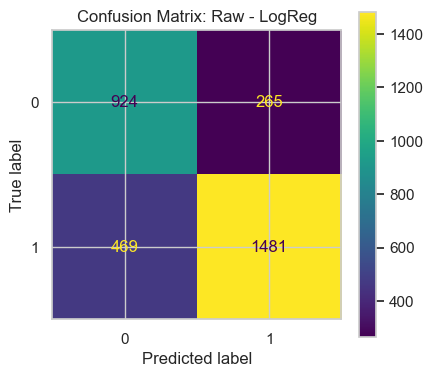

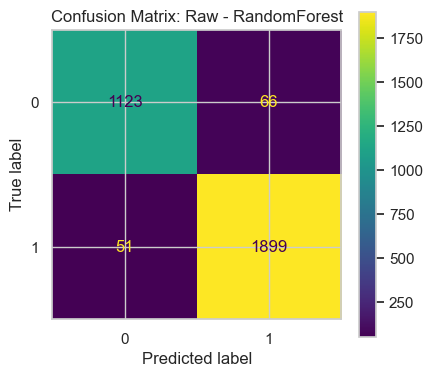

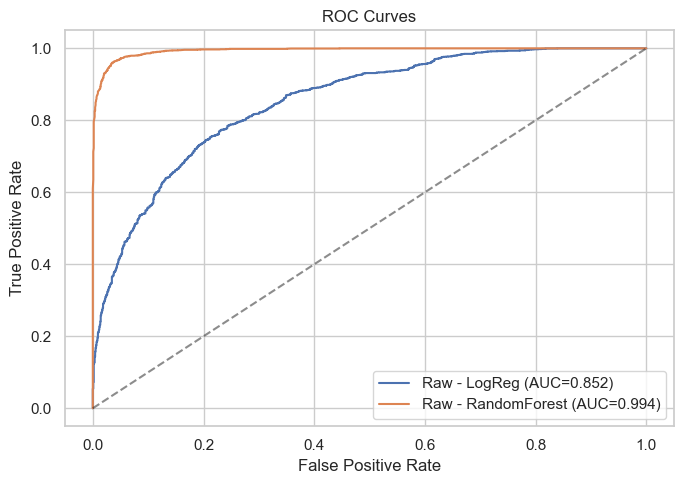

,accuracy,precision,recall,f1,roc_auc
model,,,,,
RandomForest,0.962727,0.966412,0.973846,0.970115,0.993799
LogReg,0.766168,0.848225,0.759487,0.801407,0.852126


In [31]:
# Train on raw (non-engineered) data
raw_results = train_and_eval(raw_train, is_engineered=False)
raw_results


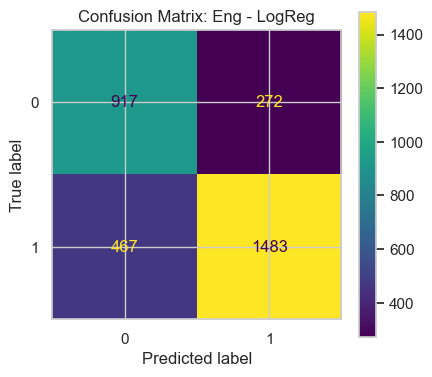

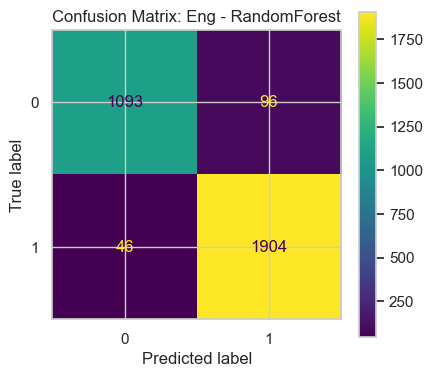

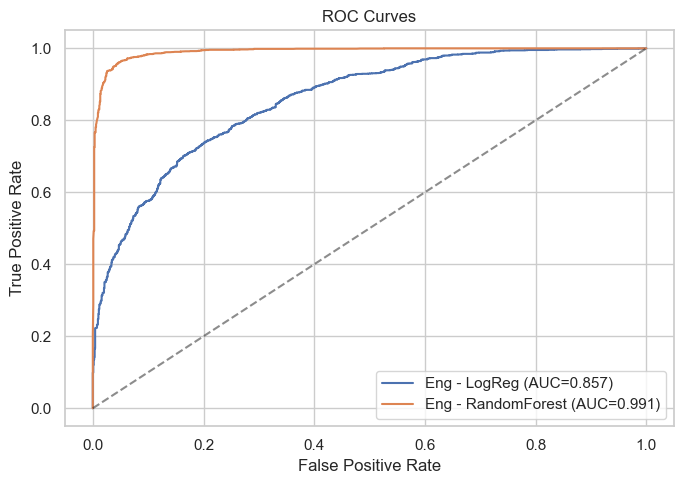

,accuracy,precision,recall,f1,roc_auc
model,,,,,
RandomForest,0.954763,0.952000,0.976410,0.964051,0.990977
LogReg,0.764575,0.845014,0.760513,0.800540,0.856843


In [32]:
# Train on engineered data
eng_results = train_and_eval(eng_train, is_engineered=True)
eng_results


In [33]:
# Consolidated comparison

comparison = pd.DataFrame({
    'metric': ['accuracy','precision','recall','f1','roc_auc'],
    'Raw_LogReg': [raw_results.loc['LogReg','accuracy'], raw_results.loc['LogReg','precision'], raw_results.loc['LogReg','recall'], raw_results.loc['LogReg','f1'], raw_results.loc['LogReg','roc_auc']],
    'Raw_RF': [raw_results.loc['RandomForest','accuracy'], raw_results.loc['RandomForest','precision'], raw_results.loc['RandomForest','recall'], raw_results.loc['RandomForest','f1'], raw_results.loc['RandomForest','roc_auc']],
    'Eng_LogReg': [eng_results.loc['LogReg','accuracy'], eng_results.loc['LogReg','precision'], eng_results.loc['LogReg','recall'], eng_results.loc['LogReg','f1'], eng_results.loc['LogReg','roc_auc']],
    'Eng_RF': [eng_results.loc['RandomForest','accuracy'], eng_results.loc['RandomForest','precision'], eng_results.loc['RandomForest','recall'], eng_results.loc['RandomForest','f1'], eng_results.loc['RandomForest','roc_auc']],
})
comparison


,metric,Raw_LogReg,Raw_RF,Eng_LogReg,Eng_RF
0,accuracy,0.766168,0.962727,0.764575,0.954763
1,precision,0.848225,0.966412,0.845014,0.952000
2,recall,0.759487,0.973846,0.760513,0.976410
3,f1,0.801407,0.970115,0.800540,0.964051
4,roc_auc,0.852126,0.993799,0.856843,0.990977


In [34]:
# Save results to CSVs for both algorithms
TEST_RESULTS_DIR = BASE_DIR / 'test_results'
TEST_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

raw_csv_path = TEST_RESULTS_DIR / 'raw_results.csv'
eng_csv_path = TEST_RESULTS_DIR / 'eng_results.csv'

raw_results.to_csv(raw_csv_path)
eng_results.to_csv(eng_csv_path)

print(f'Saved raw results to: {raw_csv_path}')
print(f'Saved engineered results to: {eng_csv_path}')


Saved raw results to: c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\test_results\raw_results.csv
Saved engineered results to: c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\test_results\eng_results.csv


In [35]:
# Create row-wise predictions merged with original test rows and save

def _select_X_for_test(df: pd.DataFrame, is_engineered: bool) -> pd.DataFrame:
    if is_engineered:
        return df.copy()
    return df[RAW_FEATURES].copy()


def score_and_join(train_df: pd.DataFrame, test_df: pd.DataFrame, is_engineered: bool) -> pd.DataFrame:
    X_train, y_train = split_xy(train_df, is_engineered=is_engineered)
    X_test = _select_X_for_test(test_df, is_engineered=is_engineered)

    numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
    # Use RandomForest for final scoring
    _, rf = make_pipeline(numeric_cols)
    rf.fit(X_train, y_train)

    won_pred = rf.predict(X_test).astype(int)
    scored = test_df.copy()
    scored['won'] = won_pred
    return scored


TEST_RESULTS_DIR = BASE_DIR / 'test_results'
TEST_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

raw_scored = score_and_join(raw_train, raw_test, is_engineered=False)
eng_scored = score_and_join(eng_train, eng_test, is_engineered=True)

raw_out = TEST_RESULTS_DIR / 'raw_test_with_predictions.csv'
eng_out = TEST_RESULTS_DIR / 'eng_test_with_predictions.csv'
raw_scored.to_csv(raw_out, index=False)
eng_scored.to_csv(eng_out, index=False)

print(f'Saved raw test with predicted won to: {raw_out}')
print(f'Saved engineered test with predicted won to: {eng_out}')


Saved raw test with predicted won to: c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\test_results\raw_test_with_predictions.csv
Saved engineered test with predicted won to: c:\Users\Admin\Desktop\Ahsham\cricket-prediction-task\test_results\eng_test_with_predictions.csv
